# 4.2.  Counterfactual Explanations
### Alex Gagliano (gaglian2@mit.edu)
### August 2nd, 2023

References and resources for additional reading:
* [Alibi Explain: Algorithms for Explaining Machine Learning Models](https://github.com/SeldonIO/alibi) (Klaise, Van Looveren, Vacanti, & Alexandru Coc, 2017)
* [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/), Christoph Molnar
* [Machine Learning Tutorials](https://github.com/MichelleLochner/ml-tutorials/tree/main), Michelle Lochner
* [Interpretable Counterfactual Explanations Guided by Prototypes](https://arxiv.org/abs/1907.02584), (Van Looveren & Klaise, 2019)

We might describe an "interpretable model" as one in which it is clear how input maps to output. We looked at SHAP values to better understand what features might have "pushed" a result in a particular direction, but another way to explore this mapping is to change the inputs and evaluate its impact on the outputs. 

In this notebook, we'll explore multi-class classification. We have examples in our training class belonging to a given class. Take an image of a spiral galaxy, for example. What do I have to modify in that image, and by how much, before my model believes that it's no longer a spiral galaxy? An example that answers this question is called a "counterfactual", which describes the smallest change to a set of feature values that will flip the predicted output. Exploring counterfactuals helps us understand what the 'boundaries' of our decision-making model are, which in turn helps us understand what features are important for decision-making. 

For a given set of input features $x$, a counterfactual $x'$ can be found by minimizing a loss function of the following general form:
$$ L(x'|x) = (f_t(x') - p_t)^2 + \lambda d(x, x')$$

Where $f_t(x')$ describes the class probability of counterfactual with features $x'$, $p_t$ defines the target class probability (how confident we want the new prediction to be), $\lambda$ is a regularization parameter that is determined during fitting, and $d(x, x')$ is some distance measure between feature sets $x$ and $x'$ (Manhattan, Euclidean, etc).

Counterfactuals, like SHAP values, are another example of a _local_ explanation model - we investigate the complex model's behavior at and near a specific set of input features.

We'll use the `alibi` package, which minimizes the above loss function and finds our counterfactuals using simple gradient descent.

In [1]:
!pip install alibi torch torchvision gdown tqdm

## 4.2.1. Image counterfactuals

In [4]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual, CounterfactualProto
import tensorflow as tf
import gdown
from tqdm import trange
tf.compat.v1.disable_eager_execution()

As before, we download our data.

In [3]:
!gdown 1s42ri7tpvBHN-kneC0MHXHsd2nB2BNTE
!gdown 1CC07axEZravXcIkq0w2gnkFGGhO4vbnx

for file in ['data', 'models']:
    subprocess.run(["tar", "-xf", "%s.tar.gz" % file]);
    
galaxyPath = './data/galaxy/'

Create our data loaders as before...

In [5]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(23)

batch_size = 8

data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()])

train = torchvision.datasets.ImageFolder(os.path.join(galaxyPath, 'train'), transform = data_transform)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)

test = torchvision.datasets.ImageFolder(os.path.join(galaxyPath, 'test'), transform = data_transform)
test_loader = DataLoader(test, shuffle=True, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(3, 20, kernel_size=5),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(720, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 3*16*15)
        x = self.fc_layers(x)
        return x

In [7]:
device = 'cpu'
model = Net().to(device)

#load the model from the SHAP tutorial!
model.load_state_dict(torch.load('./models/galaxyCNN_legacy.pth'))

<All keys matched successfully>

In [8]:
model.eval()

# Note! A pytorch model's forward function returns a tensor and not a numpy array. 
# We have to do slightly more work to get the counterfactual package to play nicely with
# the model we've trained.
@torch.no_grad()
def predictor(X: np.ndarray) -> np.ndarray:
    X = torch.as_tensor(X,dtype=torch.float, device=device)
    return model.forward(X).cpu().numpy()

In [11]:
#gather the next batch from the dataset
image, label = next(iter(test_loader)) 
X = image[6:7]

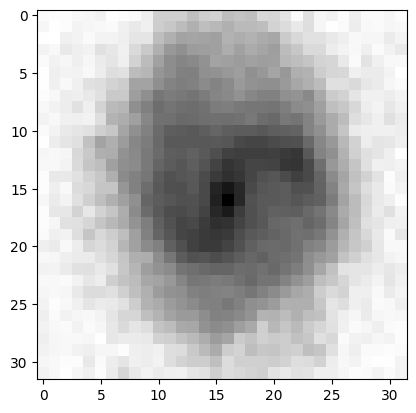

In [12]:
#here our instance of choice is the following image:
plt.imshow(X.squeeze(0,1), cmap='gray');

In [13]:
_, prediction = torch.max(model(X), 1)

In [14]:
GalaxyClasses = {0:'Ellip.', 1:'Spiral', 2:'Irreg.'}

predClass = GalaxyClasses[prediction.item()]
trueClass = GalaxyClasses[label[6].item()]

print("The predicted class is %s." % predClass)
print("The true class is %s." % trueClass)

The predicted class is Spiral
The true class is Spiral


In [15]:
tf.keras.backend.clear_session()

# initialize explainer
shape = (1,) + image.shape[1:]

cf = Counterfactual(predictor, shape, distance_fn='l1', target_proba=1.0,
                    target_class='other', max_iter=100, early_stop=50, lam_init=1e-1,
                    max_lam_steps=10, tol=0.05, learning_rate_init=0.1,
                    feature_range=(0, 1), eps=0.01, init='identity',
                    decay=True, write_dir=None, debug=False)

In [16]:
start_time = time()
explanation = cf.explain(X);
print('Explanation took {:.3f} sec.'.format(time() - start_time))

Explanation took 35.198 sec.


Counterfactual prediction: Irreg. with probability 0.9555073976516724


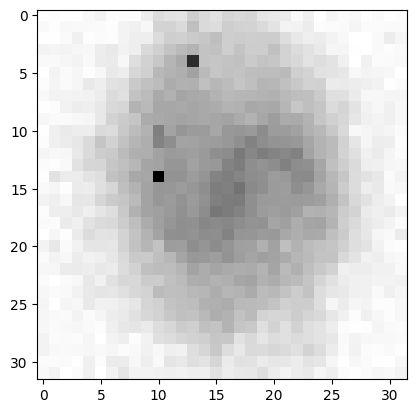

In [17]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {GalaxyClasses[pred_class]} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(32, 32), cmap='gray');

## Challenge: Consider the ensemble case. Try transforming the image (rotation, flip, slightly changing pixel values) and generating additional counterfactual examples. What does that tell us about what our model is sensitive to?
Some helpful functions are `torch.rot90` and `torch.flip`. 

Explanation took 42.349 sec.
Counterfactual prediction: Irreg. with probability 0.9506776928901672


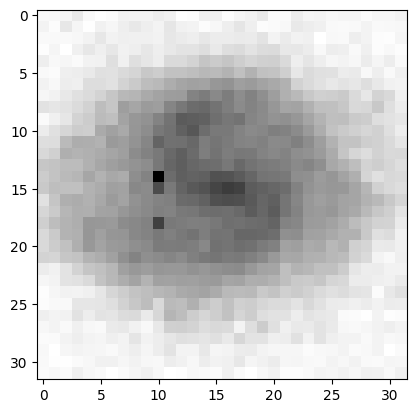

Explanation took 45.325 sec.
Counterfactual prediction: Irreg. with probability 0.9524009823799133


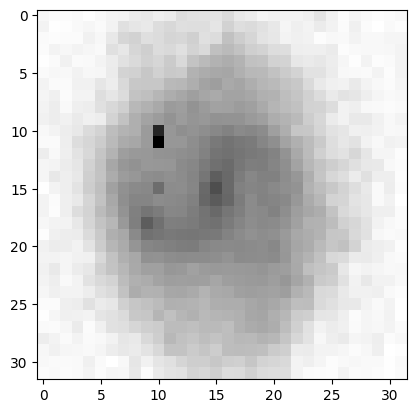

Explanation took 41.279 sec.
Counterfactual prediction: Irreg. with probability 0.9521716833114624


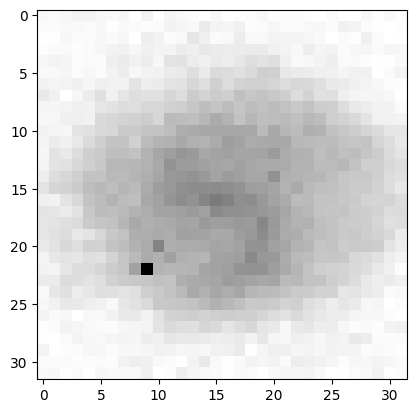

Explanation took 28.394 sec.
Counterfactual prediction: Irreg. with probability 0.996315062046051


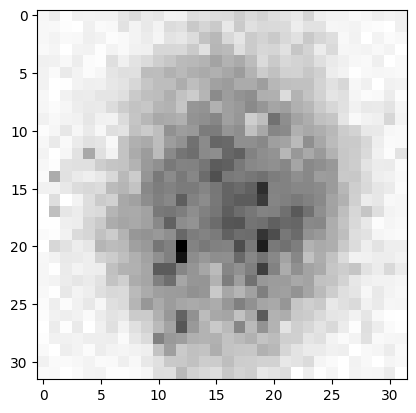

In [18]:
X_rot90 = torch.rot90(X, k=1, dims=[2, 3])
X_rot180 = torch.rot90(X, k=2, dims=[2, 3])
X_rot270 = torch.rot90(X, k=3, dims=[2, 3])
X_flip = torch.flip(X, [1, 2])

for X_transform in [X_rot90, X_rot180, X_rot270, X_flip]:
    start_time = time()
    #note - some of these might take a few minutes to find.
    explanation = cf.explain(X_transform);
    print('Explanation took {:.3f} sec.'.format(time() - start_time))
    pred_class = explanation.cf['class']
    proba = explanation.cf['proba'][0][pred_class]

    print(f'Counterfactual prediction: {GalaxyClasses[pred_class]} with probability {proba}')
    plt.imshow(explanation.cf['X'].reshape(32, 32), cmap='gray');
    plt.show()

### This turns out to be a disappointingly common phenomenon and has given rise to [one-pixel attacks](https://arxiv.org/abs/1710.08864), to which many deep networks are vulnerable.

The example seems trivial but the insight doesn't need to be. It looks like the model learned that irregular galaxies often have bright spots off-center in their respective images, though the model doesn't understand what a _physical_ bright spot looks like (no point-spread function here!).  We could continue to re-run for additional counterfactuals and confirm that's what the network considers archetypal for its class.

During the fitting technique, the regularization parameter $\lambda$ is slowly changed to 

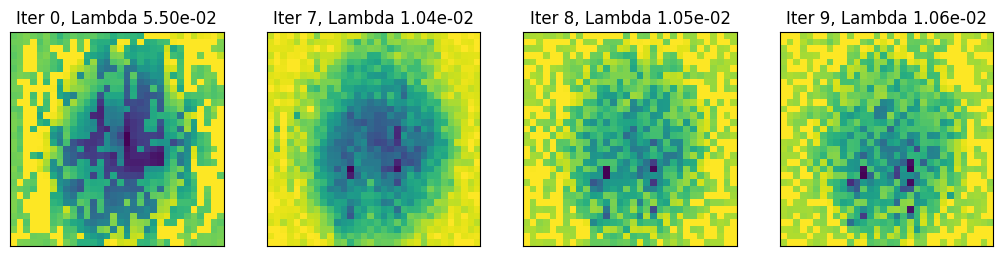

In [35]:
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(10)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(32,32))
    lam = examples[key]['lambda']
    plt.title(f'Iter {key}, Lambda {lam:.2e}')

Each of these is technically a counterfactual of the original image, but with slightly different regularization parameters determining how similar the new features $x'$ are to the input features $x$. Now let's see what it takes to point the counterfactual toward a specific class - this time we'll aim for creating an elliptical classification.

In [39]:
target_class = 0 # elliptical galaxy

tf.keras.backend.clear_session()

cf = Counterfactual(predictor, shape, distance_fn='l1', target_proba=1.0,
                    target_class=target_class, max_iter=100, early_stop=50, lam_init=1e-1,
                    max_lam_steps=10, tol=0.05, learning_rate_init=0.01,
                    feature_range=(0, 1), eps=0.01, init='identity',
                    decay=True, write_dir=None, debug=False)

explanation = start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 16.756 sec


Our counterfactual is now the following:

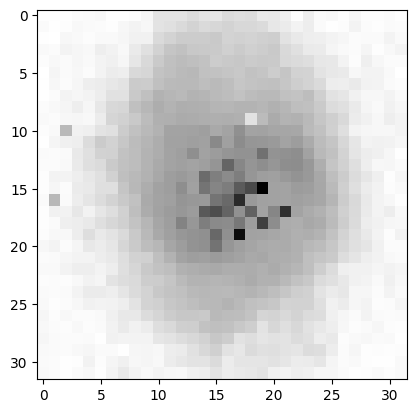

In [40]:
plt.imshow(explanation.cf['X'].reshape(32, 32), cmap='gray');

And to confirm that this would have indeed been classified as an elliptical:

In [41]:
pred_class = explanation.cf['class']

print(f'Counterfactual prediction: {GalaxyClasses[pred_class]} with probability {proba}')

Counterfactual prediction: Ellip. with probability 0.996315062046051


It looks like a bright central region is archetypal of an elliptical, though the structure in the image leaves a fair bit to be desired. 

## 4.2.2. Time-series Counterfactuals

Next, we'll explore counterfactuals from the realm of supernova science. Supernovae are the explosive deaths of stars, and we detect these phenomena as transient events in data from (typically) optical telescopes. As our discovery rates have grown, we've resorted to characterizing these events by photometry alone - spectroscopic follow-up is too resource-intensive to study everything. The large associated data volumes and the subtle differences between photometric samples makes this a natural case study for machine learning classification tools.

Let's first look at some simulated supernova photometry. These data are obtained from the Photometric Supernova Classification Challenge (SPCC, Kessler et al. 2010), and presented in $griz$ passbands from the Dark Energy Survey (DES).

In [45]:
!pip install sncosmo iminuit

In [2]:
import sncosmo
from astropy.table import Table
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
transientPath = './data/supernova/lightcurves/'

lc_file = os.path.join(transientPath, '34.dat')
lc = Table.read(lc_file, format='ascii')

In [52]:
print(lc)

        mjd          filter  flux flux_error  zp  zpsys
-------------------- ------ ----- ---------- ---- -----
                 0.0   desg 95.18      5.147 27.5    ab
0.008000000001629815   desr 116.1      3.062 27.5    ab
0.023999999997613486   desi 102.8        3.7 27.5    ab
0.046999999998661224   desz 103.7      3.153 27.5    ab
   2.997000000003027   desg 174.7      4.272 27.5    ab
   3.004000000000815   desr 176.1       3.73 27.5    ab
  3.0429999999978463   desi 165.5      3.691 27.5    ab
  3.0750000000043656   desz 150.9      4.676 27.5    ab
   4.075000000004366   desg 192.3      4.531 27.5    ab
  4.0900000000037835   desr 194.6      3.888 27.5    ab
   4.105999999999767   desi 190.3      5.135 27.5    ab
   4.137000000002445   desz 154.4      5.336 27.5    ab
  11.969000000004598   desg 265.6      7.768 27.5    ab
  11.985000000000582   desr 299.6       7.97 27.5    ab
  12.020000000004075   desi 272.3      6.839 27.5    ab
  12.046999999998661   desz 198.5       5.03 27.

A common pre-processing step is `feature extraction`: a model is fit to the supernova photometry and classification is done with these model features. Here, we'll fit a light curve to SALT2 (Guy et al., 2007), which was created for type Ia supernovae.

Dropping following bands from data: desg(out of model wavelength range)


Best fitting SALT2 parameters: [z, t0, x0, x1, c]:
[ 7.28385580e-01  1.98758379e+01  2.50842809e-05  2.20457380e+00
 -2.65958520e-01]


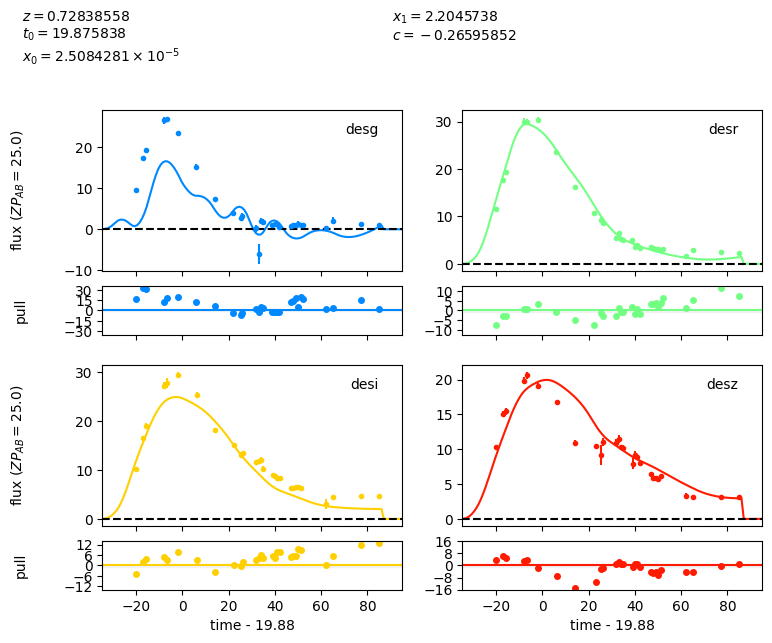

In [53]:
def fit_supernova(lc):
    """
    Small function to fit a light curve with the SALT2 model, using sncosmo and iminuit.
    
    Parameters
    -----------
    lc : astropy.table.Table
        Light curve (in the format sncosmo expects)
    
    Returns
    ----------
    z, t0, x0, x1, c
        Best-fitting parameters of the model
    """
    bnds = {'z':(0.01, 1.5), 't0':(-100,100),'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names, bounds=bnds, minsnr=0)
    return res[0].parameters

prms = fit_supernova(lc)
print('Best fitting SALT2 parameters: [z, t0, x0, x1, c]:')
print(prms)

mod = sncosmo.Model('salt2-extended')
mod.parameters = prms
sncosmo.plot_lc(lc, mod);

The SALT2 features for all supernovae in this sample have been pre-computed, and the classifications are given (1 = Ia, 2 = II, 3 = Ibc). Let's construct a basic Support Vector Machine (SVM) classifier.

In [54]:
SNclasses = {1:'SN Ia', 2:'SN II', 3:'SN Ibc'}

In [55]:
salt2_features = np.loadtxt(os.path.join('data/supernova/','salt2_features.txt'), comments='#')
labels = np.loadtxt(os.path.join('data/supernova/','labels.txt'), comments='#')

from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X = SS.fit_transform(salt2_features[:, 1:])
y = labels[:, 1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#re-balance the training set: 
under = RandomUnderSampler(random_state=42, sampling_strategy={2: 500, 1: 404, 3: 190})
over = RandomOverSampler(random_state=42, sampling_strategy={2: 500, 1: 500, 3: 500})
steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps=steps)
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

In [56]:
#Create a Support Vector Machine Classifier
clf = svm.SVC(kernel='rbf', probability=True) 

#Train the model
clf.fit(X_train_res, y_train_res)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

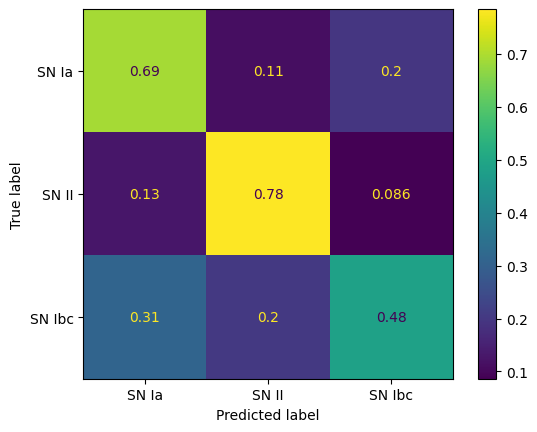

In [57]:
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SNclasses.values())
disp.plot();

Not horrible. Now let's compute some counterfactuals for a single example. First looking at the event for which we'd like a counterfactual:

Event is an SN Ia.


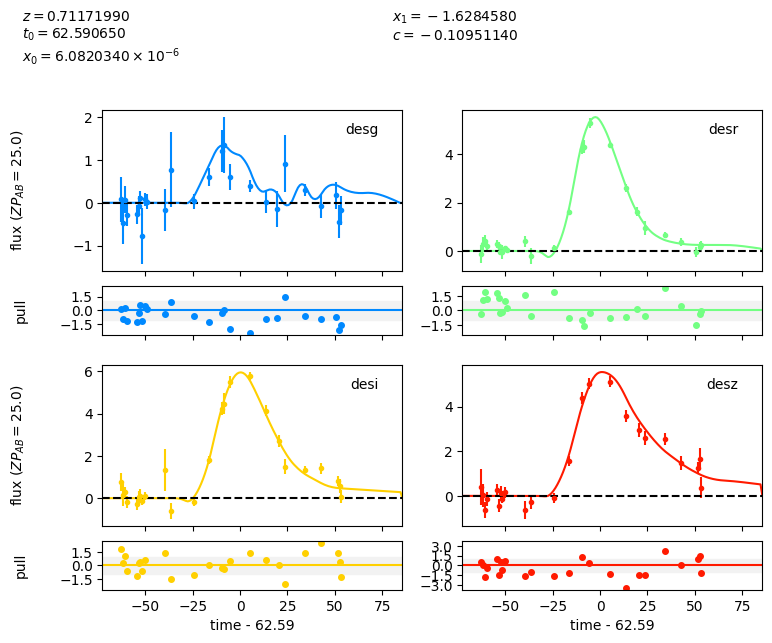

In [59]:
idx = 5

lc_file = os.path.join(transientPath, '%i.dat'%idx)
lc = Table.read(lc_file, format='ascii')

mod_orig = sncosmo.Model('salt2-extended')
mod_orig.parameters = salt2_features[idx][1:]
sncosmo.plot_lc(lc, mod_orig);

print("Event is an %s." % SNclasses[labels[idx, 1]])

As before, let's generate a counterfactual:

In [67]:
predictor = lambda x: clf.predict_proba(x)

tf.keras.backend.clear_session()

shape = (1,) + X[idx].reshape(1, -1).shape[1:]

cf = Counterfactual(predictor, shape, distance_fn='l1', target_proba=1.0,
                    target_class=1, max_iter=1000, lam_init=1e-5,
                    max_lam_steps=50, tol=0.05, learning_rate_init=0.1,
                    feature_range=(-1.e5, 1.e5), eps=0.01, init='identity',
                    decay=True, write_dir=None, debug=False)

explanation = start_time = time()
explanation = cf.explain(X[idx].reshape(1, -1))
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 12.742 sec


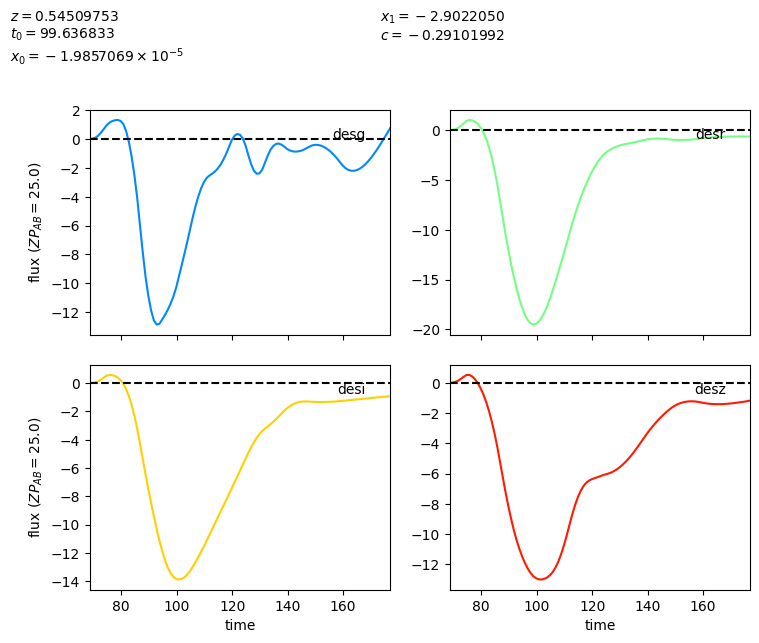

In [68]:
mod_counter = sncosmo.Model('salt2-extended')
mod_counter.parameters = SS.inverse_transform(explanation.cf['X'][0].reshape(1, -1))[0]
sncosmo.plot_lc(data=None, bands=['desg','desr', 'desi', 'desz'], model=mod_counter);

The scale seems roughly right, but the most obvious flaw is that the counterfactual supernova _dims_ instead of _brightening_. 

## Challenge: Implement another classification method and generate another set of counterfactuals for a few inputs. Do some models have more naturally interpretable counterfactuals (and corresponding decision boundaries) than others? 

To get counterfactuals more closely matching the training dataset, we can use _prototypes_. This trick comes from a paper in 2019, [Interpretable Counterfactual Explanations Guided by Prototypes](https://arxiv.org/abs/1907.02584). By adding a term $L_{\rm{proto}}$ to the loss function, we can guide our counterfactuals toward examples that fall within the data distribution _and_ differ from our sample class $i$. The additional term is defined as 
$$
L_{\rm{proto}} = \theta \;  || ENC(x+\delta) - \rm{proto}_j||_2^2
$$
where $i \neq j$. This term penalizes counterfactuals far from a given prototype, with the distance measured in the latent space of the encoding. To make this work, however, we need a way of _encoding_ our counterfactual $x+\delta$ and a pre-defined set of class prototypes in the same encoding space. How do we create these?

Two examples from the 2019 paper (but surely not an exhaustive list) are:

* Autoencoders
* kd-trees

We'll explore the second example below.

In [69]:
tf.keras.backend.clear_session()

cf = CounterfactualProto(predictor, shape, use_kdtree=True, theta=100., feature_range=(-1.e3, 1.e3))
cf.fit(X_train, trustscore_kwargs=None)
explanation = cf.explain(X[5].reshape(1, -1),  k=2)

No encoder specified. Using k-d trees to represent class prototypes.


and now, let's investigate the counterfactual. What class is it predicted to be?

In [70]:
pred_class = explanation.cf['class']
print(f'Counterfactual prediction: {SNclasses[pred_class]}')

Counterfactual prediction: SN II


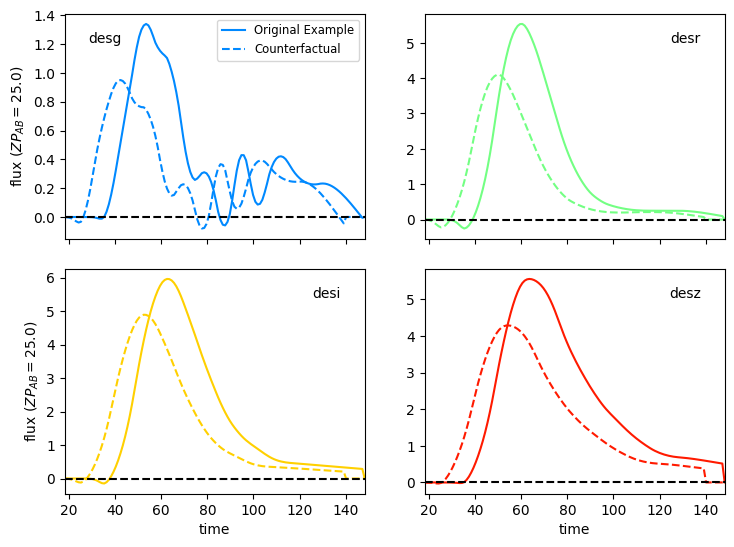

In [71]:
#and now, the counterfactual
mod_counter.parameters = SS.inverse_transform(explanation.cf['X'][0].reshape(1, -1))[0]
sncosmo.plot_lc(data=None, bands=['desg','desr', 'desi', 'desz'], model=[mod_orig, mod_counter], model_label=['Original Example', 'Counterfactual']);

Note that because we're using kdtrees, our prototypes are actual examples from our training set. In the autoencoder case, the prototypes are defined as the average of the k-nearest encodings of a given class $i \neq j$.

In [72]:
#let's see how the input parameters differ; this is what needs to be changed to take us from an SN Ia to an SN II
counter_params =  SS.inverse_transform(explanation.cf['X'][0].reshape(1, -1))[0]
initial_params =  SS.inverse_transform(X[5].reshape(1, -1))[0]
parm_diffs = counter_params - initial_params

In [73]:
print("SALT2 parameters: [z, t0, x0, x1, c]")
print("Absolute parameter changes")
print(parm_diffs)
print("Fractional parameter changes")
print(parm_diffs/initial_params)

SALT2 parameters: [z, t0, x0, x1, c]
Absolute parameter changes
[ 2.42007080e-02 -9.67880002e+00 -1.38850292e-06 -2.30712889e-08
  2.22101211e-09]
Fractional parameter changes
[ 3.40031353e-02 -1.54636516e-01 -2.28295816e-01  1.41675676e-08
 -2.02811042e-08]


These parameters are redshift (z), starting time (t0), amplitude (x0), light curve stretch (x1), and color (c). 

The counterfactual, then, has about the same redshift, but looks dimmer than the example event and starts earlier. Our counterfactual both looks like a supernova now, and has some desirable physical properties: type Ia supernovae are significantly brighter than SNe II on average, and we see this in our case. 

We can also calculate counterfactuals guided by autoencoder-defined prototypes. 
# Challenge: Create an autoencoder for our galaxy images and generate a few counterfactuals for our galaxy classification model. Are the results more interpretable than the earlier examples? What do you notice?

Note - in the autoencoder prescription first outlined in the 2019 paper, the distance term in the loss function $\lambda d(x, x')$ is replaced with the elastic net regularizer we saw on Day 1, and for the same reason: to ensure sparse & interpretable counterfactuals:
$$
\lambda d(x, x') \rightarrow \beta ||x - x'||_1 + ||x-x'||_2^2
$$
Some helpful code is given below:

## Warning!! The training gradients reveal that alibi's autoencoder functionality only works for tensorflow (and not Pytorch) models at the moment. This example will be worked out in a following version of the notebook.

In [11]:
class ae(nn.Module):
    def __init__(self):
        super(ae, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(64, 32, 7)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        # Encoder
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        return x

    def decode(self, x):
        # Decoder
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.sigmoid(self.deconv3(x))
        return x

    def forward(self, x):
        return self.decode(self.encode(x))

ae_model = ae().to(device)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters(), lr=1.e-4)

train_loss = []
for epoch in trange(100):  # loop over the dataset multiple times
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = ae_model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
    train_loss.append(running_loss / len(train_loader.dataset))
print('Finished Training')

100%|█████████████████████████████████████████| 100/100 [03:33<00:00,  2.14s/it]

Finished Training


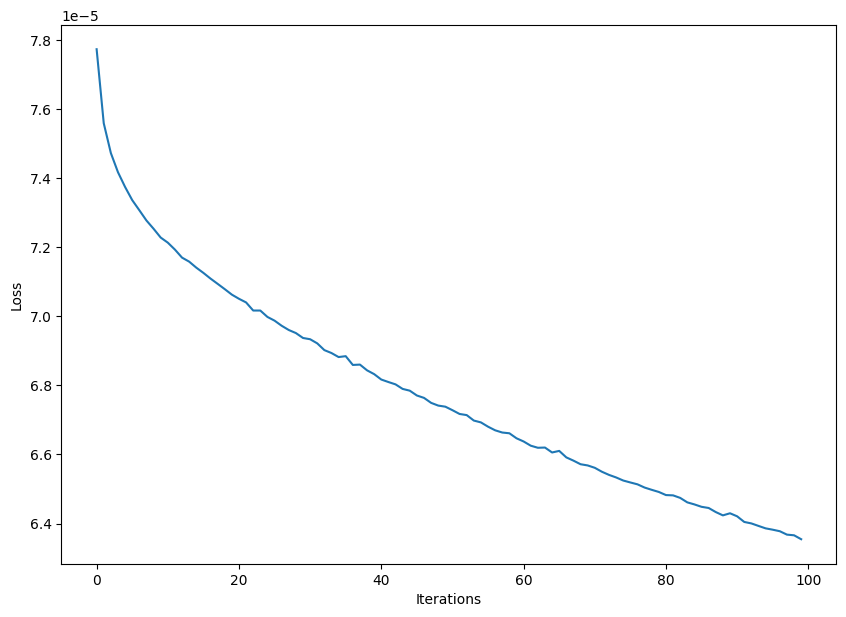

In [12]:
plt.figure(figsize=(10,7))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_loss);

Not done training, but enough for an example.

How well do we do on the test set?

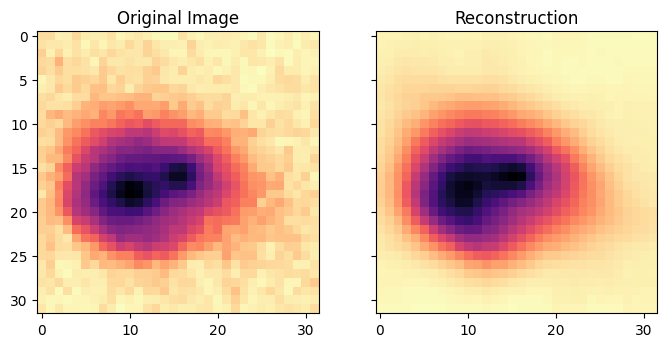

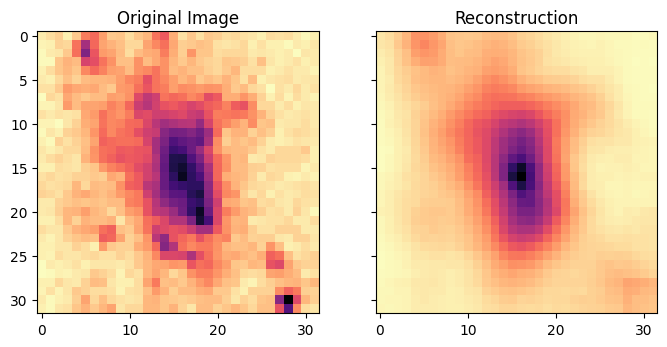

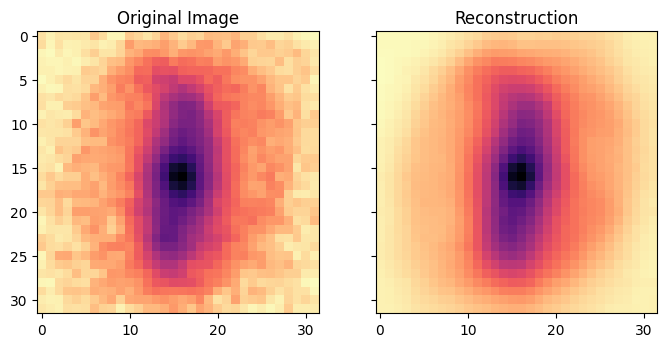

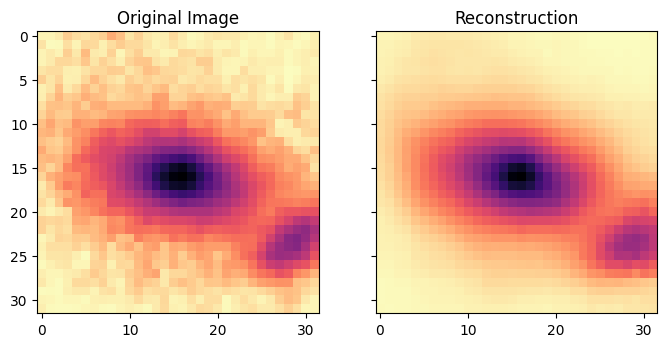

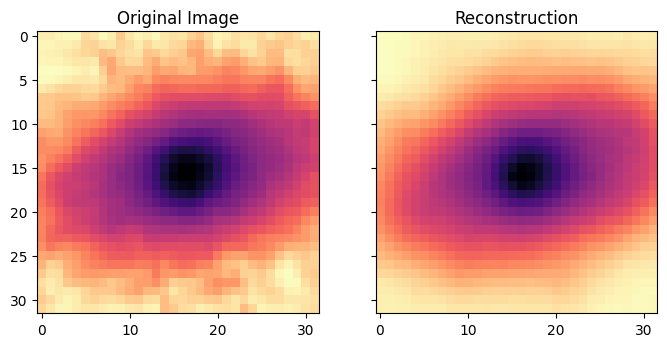

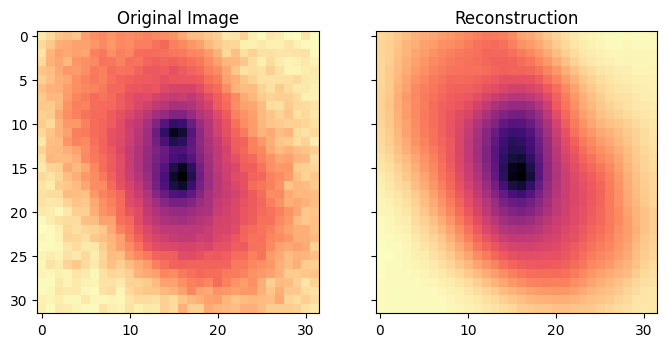

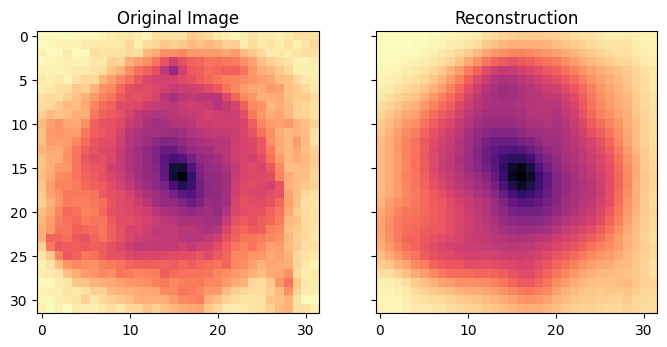

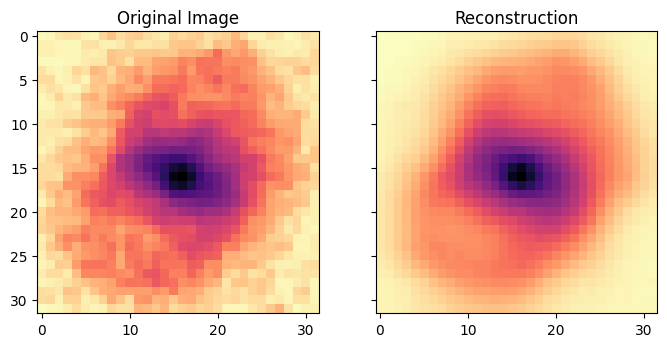

In [14]:
(image, _) = next(iter(test_loader))

for i, img in enumerate(image):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
    # Reshape the array for plotting
    recon_img = ae_model(image[i]).detach().squeeze().numpy()
    ax1.imshow(image[i].squeeze(), cmap='magma')
    ax1.set_title("Original Image")
    ax2.imshow(recon_img, cmap='magma')
    ax2.set_title("Reconstruction")
    plt.show()

In [12]:
#torch.save(ae_model.state_dict(), './models/ae_model_legacy.pth')
ae_model.load_state_dict(torch.load('./models/ae_model_legacy.pth'))

<All keys matched successfully>

Pretty good, and now we generate our counterfactuals.

In [41]:
tf.compat.v1.disable_eager_execution()
tf.keras.backend.clear_session()

#increase the batch size so that we have enough samples to pass to find the average encoder prototypes
train_loader_proto = DataLoader(train, shuffle=True, batch_size=512, worker_init_fn=seed_worker, generator=g)
images_proto, labels_proto = next(iter(train_loader_proto))

# set some default parameters for the fit
c_init = 1.
c_steps = 1
max_iterations = 100
beta = 0.0    # elastic net regularization loss term - turned off for now
gamma = 100.  # autoencoder reconstruction loss term
theta = 100.  # prototype proximity loss term

# initialize explainer
shape = (1,) + image.shape[1:]

@torch.no_grad()
def predictor(X: np.ndarray) -> np.ndarray:
    X = torch.as_tensor(X,dtype=torch.float, device=device)
    return model.forward(X).cpu().numpy()

# initialize explainer, fit and generate counterfactual
cf = CounterfactualProto(predictor, shape, beta=beta, gamma=gamma, theta=theta,
                         ae_model=ae_model, enc_model=ae_model.encode, max_iterations=max_iterations,
                         feature_range=(0, 1), c_init=c_init, c_steps=c_steps)

start_time = time()
cf.fit(images_proto)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))

Time to find prototypes each class: 0.007 sec


Explanation took 1.863 sec
True class : Ellip.
Counterfactual class: Spiral


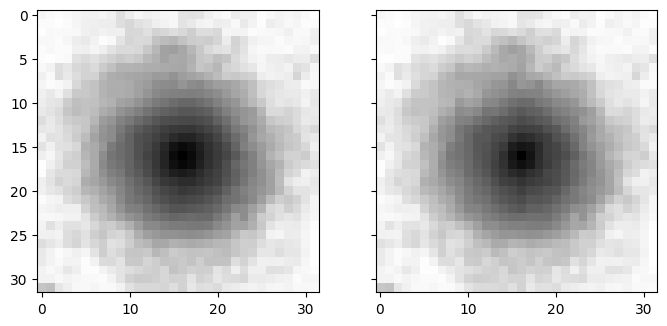

No counterfactual found!


Explanation took 9.949 sec
True class : Spiral
Counterfactual class: Ellip.


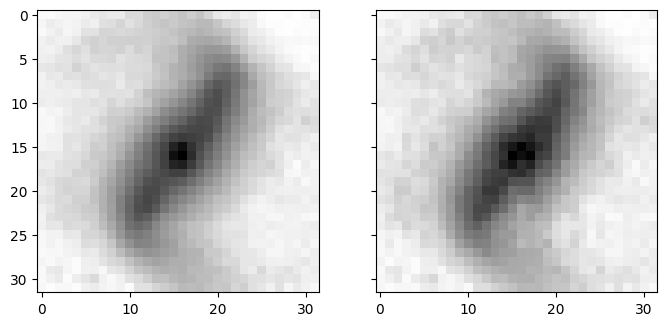

Explanation took 11.855 sec
True class : Irreg.
Counterfactual class: Spiral


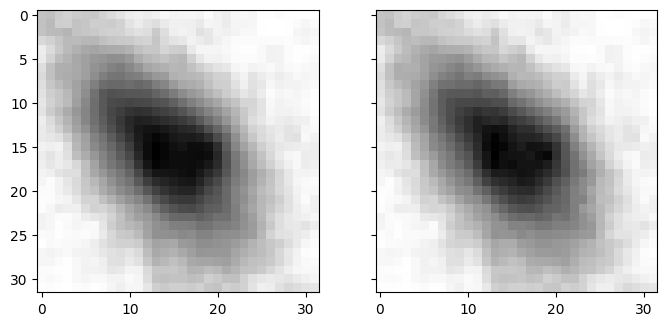

In [43]:
image, labels = next(iter(test_loader))

start_time = time()
for i in np.arange(len(image)-1):
    explanation = cf.explain(image[i:i+1])
    # the case where the convergence failed:
    if (not (explanation.cf) or (labels[i].item() == explanation.cf['class'])):
        continue 
    print('Explanation took {:.3f} sec'.format(time() - start_time))
    print("True class : {}".format(GalaxyClasses[labels[i].item()]))
    print('Counterfactual class: {}'.format(GalaxyClasses[explanation.cf['class']]))  
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
    ax1.imshow(image[i].squeeze(), cmap='gray');
    ax2.imshow(explanation.cf['X'].reshape(32, 32), cmap='gray');
    plt.show()